# Using Sentiment Analysis of User Reviews and Natural Language Processing to Assess Usability in Mobile Health Applications.

### Import some necessary python libraries.

In [1]:
import pandas as pd
import numpy as np
import sys
import pandas as pd
import seaborn as snsy
import re
import os
import spacy
import matplotlib.pyplot as plt

In [2]:
import gensim
from gensim.utils import simple_preprocess
import spacy
from sklearn.feature_extraction.text import CountVectorizer
#To suppress unnecessary warning messages.
import warnings
warnings.filterwarnings('ignore')

### Load and Explore the two datasets. 

In [3]:
### The patientportal_df contains user reviews while the metadata_df contains app related information.

In [4]:
# Load the csv files using pandas. These will be merged later on so as to have a rich dataset.
patientportal_df = pd.read_csv('patientportal_data.csv')
metadata_df = pd.read_csv('patientportal_metadata.csv')

## Exploring the 'patientportal' dataset.

In [5]:
# Display the first few rows to check the data
patientportal_df

,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,app_name,app_id
0,0,bd0c5057-e84d-4821-9c73-75d64c0ab12c,Allison Cook,https://play-lh.googleusercontent.com/a-/ALV-U...,"I absolutely love this APP. It's convenient, a...",4,15,1.11.1,2023-08-17 19:31:01,"Hello Allison, we're pleased to hear you love ...",2023-08-21 13:57:16,athenaPatient,com.athenahealth.athenapatient
1,1,0d0f096a-dc38-44a2-aab2-091b3bfbffd9,Stephanie Marie,https://play-lh.googleusercontent.com/a/ACg8oc...,This app needs a lot of improvement. It's not ...,1,3,1.3.0,2023-09-18 13:27:52,"Hello Stephanie, Thank you for your feedback. ...",2023-09-18 15:01:41,athenaPatient,com.athenahealth.athenapatient
2,2,33b91463-4ea5-4370-9db9-66f17c4a835c,Javier&Kristi Cervantes,https://play-lh.googleusercontent.com/a-/ALV-U...,"App opens to browser, there literally is no po...",1,13,1.4.1,2023-03-28 13:44:42,"Hello Mr. and Mrs. Cervantes, It sounds like y...",2023-03-28 13:41:25,athenaPatient,com.athenahealth.athenapatient
3,3,08918ccd-95b9-46ef-ad99-70e9f4c43809,Kelly N.,https://play-lh.googleusercontent.com/a-/ALV-U...,Doesn't work & no tech support. I already have...,1,32,1.4.1,2023-03-27 11:05:10,"Hi Kelly, thank you for reaching out. You will...",2023-03-27 15:24:37,athenaPatient,com.athenahealth.athenapatient
4,4,e6e30360-9306-44ea-8bcd-c01ecabe7cba,Lisa Campo Hidalgo,https://play-lh.googleusercontent.com/a/ACg8oc...,Once you put in your password it redirects you...,1,7,1.12.1,2023-10-23 10:14:51,"Hello Lisa, we apologize for the inconvenience...",2023-10-24 21:08:25,athenaPatient,com.athenahealth.athenapatient
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111984,111984,da20126c-5d92-4dd3-b351-bd33448d15b8,Dave Penn,https://play-lh.googleusercontent.com/a/ACg8oc...,Awesome,5,0,0.9.0(352053),2022-08-14 11:54:42,NaN,NaN,Patient Portal,com.flowhealth.mp_android.patient
111985,111985,0d8183ba-91a3-4d71-b719-eb36155be0da,Todd,https://play-lh.googleusercontent.com/a/ACg8oc...,Lousy,1,1,0.6.0(351632),2022-06-20 12:45:02,NaN,NaN,Patient Portal,com.flowhealth.mp_android.patient
111986,111986,c8623e51-22e1-410b-8617-f8fcc8df18ba,John Casanova,https://play-lh.googleusercontent.com/a-/ALV-U...,Great app.,5,2,0.2.102983,2021-12-23 10:00:45,NaN,NaN,Patient Portal,com.flowhealth.mp_android.patient
111987,111987,0a566f6b-9239-4b30-8fb9-79ee95a33dcb,john,https://play-lh.googleusercontent.com/a-/ALV-U...,Cool,5,4,NaN,2021-09-24 04:53:53,NaN,NaN,Patient Portal,com.flowhealth.mp_android.patient


### Exploring the 'metadata' dataset.

In [6]:
# For the second as well, display the first few rows to check the data
metadata_df

,Unnamed: 0,title,description,descriptionHTML,summary,installs,minInstalls,realInstalls,score,ratings,...,videoImage,contentRating,contentRatingDescription,adSupported,containsAds,released,updated,version,appId,url
0,0,athenaPatient,athenaPatient is only available for patients w...,athenaPatient is only available for patients w...,Access health information and communicate with...,"100,000+",100000,191401,3.235294,232,...,NaN,Everyone,NaN,False,False,"Nov 9, 2022",1698951847,1.13.0,com.athenahealth.athenapatient,https://play.google.com/store/apps/details?id=...
1,1,FollowMyHealth®,Access and manage your health information on-t...,Access and manage your health information on-t...,Manage your healthcare through the FollowMyHea...,"5,000,000+",5000000,5797309,4.745418,167718,...,NaN,Everyone,NaN,False,False,"Aug 6, 2012",1697831699,23.4,com.jardogs.fmhmobile,https://play.google.com/store/apps/details?id=...
2,2,Patient Portal,Through the Patient Portal Web Shortcut from N...,Through the Patient Portal Web Shortcut from N...,"View your medical record, make appointments, r...","100,000+",100000,270051,2.410000,463,...,NaN,Everyone,NaN,False,False,"Oct 25, 2016",1477416772,1.0,com.nextmd.nextgenpp,https://play.google.com/store/apps/details?id=...
3,3,MEDITECH MHealth,MHealth is the mobile version of MEDITECH’s Pa...,MHealth is the mobile version of MEDITECH’s Pa...,MHealth is the mobile version of MEDITECH’s Pa...,"500,000+",500000,631079,3.190840,1446,...,NaN,Everyone,NaN,False,False,"Jun 12, 2017",1683923066,1.16.0,com.meditech.PatientPhm,https://play.google.com/store/apps/details?id=...
4,4,MyChart,MyChart puts your health information in the pa...,MyChart puts your health information in the pa...,MyChart for Android,"10,000,000+",10000000,20105747,4.565401,160930,...,NaN,Everyone,NaN,False,False,"Oct 31, 2011",1696874860,10.6.3,epic.mychart.android,https://play.google.com/store/apps/details?id=...
5,5,My Health at Vanderbilt,My Health at Vanderbilt is a secure tool that ...,My Health at Vanderbilt is a secure tool that ...,My Health at Vanderbilt securely puts your hea...,"100,000+",100000,149320,4.606452,1558,...,NaN,Everyone,NaN,False,False,"May 18, 2016",1696520202,10.6.2,com.ta.mhav,https://play.google.com/store/apps/details?id=...
6,6,HealtheLife,HealtheLife helps individuals and families sta...,HealtheLife helps individuals and families sta...,HealtheLife lets you easily manage your health...,"500,000+",500000,839510,2.660099,2099,...,NaN,Everyone,NaN,False,False,"Oct 26, 2015",1698335694,102.0.23,com.cerner.iris.play,https://play.google.com/store/apps/details?id=...
7,7,MyHealthONE,The MyHealthONE app features are designed with...,The MyHealthONE app features are designed with...,Patient Health Portal,"100,000+",100000,381513,4.332653,4903,...,NaN,Everyone,NaN,False,False,"Mar 25, 2020",1699378068,1.4.6,com.hcahealthcare.mhom,https://play.google.com/store/apps/details?id=...
8,8,Patient Portal,The Flow Health Patient Portal provides you wi...,The Flow Health Patient Portal provides you wi...,Flow Health Patient Portal,"50,000+",50000,76224,4.460000,521,...,NaN,Everyone,NaN,False,False,"Aug 13, 2021",1687187370,0.24.0(354123),com.flowhealth.mp_android.patient,https://play.google.com/store/apps/details?id=...


### Overview of the 'patientportal_df' DataFrame Structure

In [7]:
# Get information about the patientportal DataFrame
patientportal_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111989 entries, 0 to 111988
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Unnamed: 0            111989 non-null  int64 
 1   reviewId              111989 non-null  object
 2   userName              111988 non-null  object
 3   userImage             111989 non-null  object
 4   content               111927 non-null  object
 5   score                 111989 non-null  int64 
 6   thumbsUpCount         111989 non-null  int64 
 7   reviewCreatedVersion  103534 non-null  object
 8   at                    111989 non-null  object
 9   replyContent          44832 non-null   object
 10  repliedAt             44832 non-null   object
 11  app_name              111989 non-null  object
 12  app_id                111989 non-null  object
dtypes: int64(3), object(10)
memory usage: 11.1+ MB


### Overview of the 'metadata_df' DataFrame Structure

In [8]:
# Get information about the metadata DataFrame
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                9 non-null      int64  
 1   title                     9 non-null      object 
 2   description               9 non-null      object 
 3   descriptionHTML           9 non-null      object 
 4   summary                   9 non-null      object 
 5   installs                  9 non-null      object 
 6   minInstalls               9 non-null      int64  
 7   realInstalls              9 non-null      int64  
 8   score                     9 non-null      float64
 9   ratings                   9 non-null      int64  
 10  reviews                   9 non-null      int64  
 11  histogram                 9 non-null      object 
 12  price                     9 non-null      int64  
 13  free                      9 non-null      bool   
 14  currency      

### Data Preparation before merging: The rename function is used to ensure that the spelling of app_id is the same in both datasets.

In [9]:
# Rename the 'appId' column to 'app_id' in metadata_df
metadata_df.rename(columns={'appId': 'app_id'}, inplace=True)

# Verify the rename was successful
metadata_df.columns


Index(['Unnamed: 0', 'title', 'description', 'descriptionHTML', 'summary',
       'installs', 'minInstalls', 'realInstalls', 'score', 'ratings',
       'reviews', 'histogram', 'price', 'free', 'currency', 'sale', 'saleTime',
       'originalPrice', 'saleText', 'offersIAP', 'inAppProductPrice',
       'developer', 'developerId', 'developerEmail', 'developerWebsite',
       'developerAddress', 'privacyPolicy', 'genre', 'genreId', 'categories',
       'icon', 'headerImage', 'screenshots', 'video', 'videoImage',
       'contentRating', 'contentRatingDescription', 'adSupported',
       'containsAds', 'released', 'updated', 'version', 'app_id', 'url'],
      dtype='object')

### Merging of the Dataframes: This merging was done  on the common column app_id between the two DataFrames.
### This will create a unified dataset that enables in-depth analysis of the relationship between user feedback and app characteristics. 

In [10]:
# Attempt to merge review_df and metadata_df on 'app_id'
app_reviews_df = pd.merge(patientportal_df, metadata_df, on='app_id', how='left')

# Check the first few rows of the combined DataFrame to ensure the merge was successful
app_reviews_df


,Unnamed: 0_x,reviewId,userName,userImage,content,score_x,thumbsUpCount,reviewCreatedVersion,at,replyContent,...,video,videoImage,contentRating,contentRatingDescription,adSupported,containsAds,released,updated,version,url
0,0,bd0c5057-e84d-4821-9c73-75d64c0ab12c,Allison Cook,https://play-lh.googleusercontent.com/a-/ALV-U...,"I absolutely love this APP. It's convenient, a...",4,15,1.11.1,2023-08-17 19:31:01,"Hello Allison, we're pleased to hear you love ...",...,NaN,NaN,Everyone,NaN,False,False,"Nov 9, 2022",1698951847,1.13.0,https://play.google.com/store/apps/details?id=...
1,1,0d0f096a-dc38-44a2-aab2-091b3bfbffd9,Stephanie Marie,https://play-lh.googleusercontent.com/a/ACg8oc...,This app needs a lot of improvement. It's not ...,1,3,1.3.0,2023-09-18 13:27:52,"Hello Stephanie, Thank you for your feedback. ...",...,NaN,NaN,Everyone,NaN,False,False,"Nov 9, 2022",1698951847,1.13.0,https://play.google.com/store/apps/details?id=...
2,2,33b91463-4ea5-4370-9db9-66f17c4a835c,Javier&Kristi Cervantes,https://play-lh.googleusercontent.com/a-/ALV-U...,"App opens to browser, there literally is no po...",1,13,1.4.1,2023-03-28 13:44:42,"Hello Mr. and Mrs. Cervantes, It sounds like y...",...,NaN,NaN,Everyone,NaN,False,False,"Nov 9, 2022",1698951847,1.13.0,https://play.google.com/store/apps/details?id=...
3,3,08918ccd-95b9-46ef-ad99-70e9f4c43809,Kelly N.,https://play-lh.googleusercontent.com/a-/ALV-U...,Doesn't work & no tech support. I already have...,1,32,1.4.1,2023-03-27 11:05:10,"Hi Kelly, thank you for reaching out. You will...",...,NaN,NaN,Everyone,NaN,False,False,"Nov 9, 2022",1698951847,1.13.0,https://play.google.com/store/apps/details?id=...
4,4,e6e30360-9306-44ea-8bcd-c01ecabe7cba,Lisa Campo Hidalgo,https://play-lh.googleusercontent.com/a/ACg8oc...,Once you put in your password it redirects you...,1,7,1.12.1,2023-10-23 10:14:51,"Hello Lisa, we apologize for the inconvenience...",...,NaN,NaN,Everyone,NaN,False,False,"Nov 9, 2022",1698951847,1.13.0,https://play.google.com/store/apps/details?id=...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111984,111984,da20126c-5d92-4dd3-b351-bd33448d15b8,Dave Penn,https://play-lh.googleusercontent.com/a/ACg8oc...,Awesome,5,0,0.9.0(352053),2022-08-14 11:54:42,NaN,...,NaN,NaN,Everyone,NaN,False,False,"Aug 13, 2021",1687187370,0.24.0(354123),https://play.google.com/store/apps/details?id=...
111985,111985,0d8183ba-91a3-4d71-b719-eb36155be0da,Todd,https://play-lh.googleusercontent.com/a/ACg8oc...,Lousy,1,1,0.6.0(351632),2022-06-20 12:45:02,NaN,...,NaN,NaN,Everyone,NaN,False,False,"Aug 13, 2021",1687187370,0.24.0(354123),https://play.google.com/store/apps/details?id=...
111986,111986,c8623e51-22e1-410b-8617-f8fcc8df18ba,John Casanova,https://play-lh.googleusercontent.com/a-/ALV-U...,Great app.,5,2,0.2.102983,2021-12-23 10:00:45,NaN,...,NaN,NaN,Everyone,NaN,False,False,"Aug 13, 2021",1687187370,0.24.0(354123),https://play.google.com/store/apps/details?id=...
111987,111987,0a566f6b-9239-4b30-8fb9-79ee95a33dcb,john,https://play-lh.googleusercontent.com/a-/ALV-U...,Cool,5,4,NaN,2021-09-24 04:53:53,NaN,...,NaN,NaN,Everyone,NaN,False,False,"Aug 13, 2021",1687187370,0.24.0(354123),https://play.google.com/store/apps/details?id=...


### Checking for data types in the merged df

In [11]:
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111989 entries, 0 to 111988
Data columns (total 56 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0_x              111989 non-null  int64  
 1   reviewId                  111989 non-null  object 
 2   userName                  111988 non-null  object 
 3   userImage                 111989 non-null  object 
 4   content                   111927 non-null  object 
 5   score_x                   111989 non-null  int64  
 6   thumbsUpCount             111989 non-null  int64  
 7   reviewCreatedVersion      103534 non-null  object 
 8   at                        111989 non-null  object 
 9   replyContent              44832 non-null   object 
 10  repliedAt                 44832 non-null   object 
 11  app_name                  111989 non-null  object 
 12  app_id                    111989 non-null  object 
 13  Unnamed: 0_y              111989 non-null  i

### Attempting to know all the mobile health applications in the dataset.

In [12]:
# Check unique values in the 'app_name' column
unique_app_names = app_reviews_df['app_name'].unique()
unique_app_names


array(['athenaPatient', 'FollowMyHealth', 'NextGen Healthcare',
       'MediTech MHealth', 'MyChart', 'MyHealth at Vanderbilt',
       'HealtheLife', 'MyHealthONE', 'Patient Portal'], dtype=object)

### Reviews available for each of the applications

In [13]:
# Count the frequency of each unique 'app_name'
app_name_counts = app_reviews_df['app_name'].value_counts()
app_name_counts


app_name
FollowMyHealth            58190
MyChart                   50325
HealtheLife                 958
MyHealth at Vanderbilt      745
MediTech MHealth            714
MyHealthONE                 596
NextGen Healthcare          258
athenaPatient               132
Patient Portal               71
Name: count, dtype: int64

### Visualize the frequency of occurrence for each of the applications.

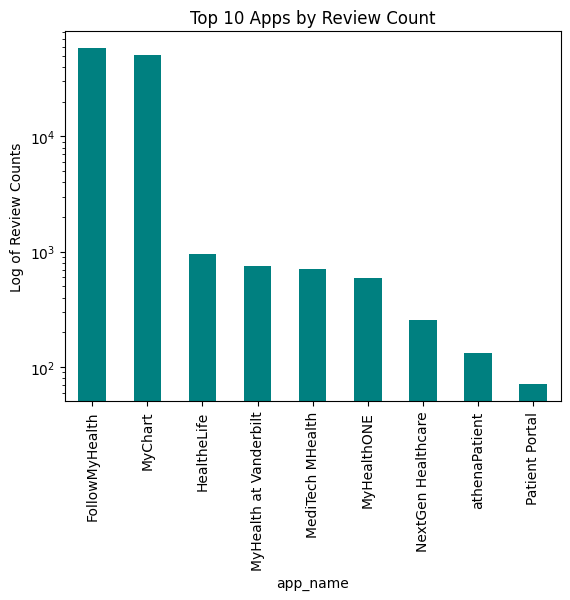

In [14]:
ax = app_name_counts.head(10).plot(kind='bar', title='Top 10 Apps by Review Count', color='teal')
ax.set_yscale('log')  # Apply log scale to the y-axis
ax.set_ylabel('Log of Review Counts')
plt.show()


### Calculating the average scores of each of the mobile health applications.

In [15]:
# Group the dataset by app name and calculate the average score for each app
app_scores = app_reviews_df.groupby('app_name')['score_x'].mean()

# Sort the scores in descending order to see the highest scoring apps first
app_scores_sorted = app_scores.sort_values(ascending=False)

# Display the results
app_scores_sorted


app_name
FollowMyHealth            4.625657
MyHealth at Vanderbilt    4.410738
MyChart                   4.158172
MyHealthONE               2.901007
athenaPatient             2.446970
HealtheLife               2.410230
MediTech MHealth          2.224090
Patient Portal            2.197183
NextGen Healthcare        1.720930
Name: score_x, dtype: float64

### Visualisation of the average scores.

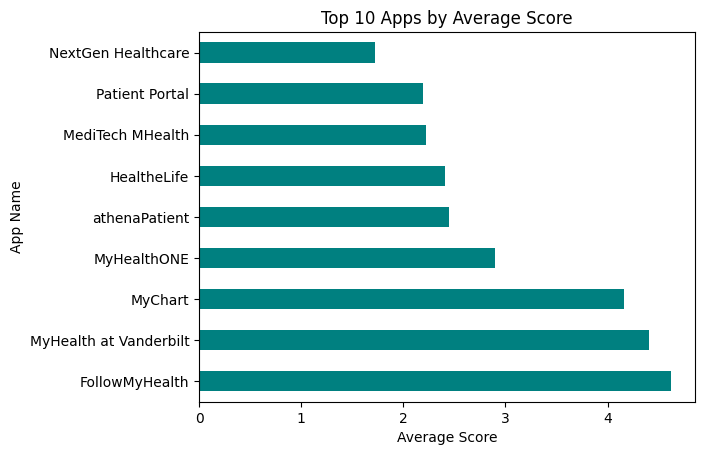

In [16]:
app_scores_sorted.head(10).plot(kind='barh', title='Top 10 Apps by Average Score', color='teal')
plt.xlabel('Average Score')
plt.ylabel('App Name')
plt.show()


### Are there missing values?

In [17]:
#Check for missing values
app_reviews_df.isnull().sum()


Unnamed: 0_x                     0
reviewId                         0
userName                         1
userImage                        0
content                         62
score_x                          0
thumbsUpCount                    0
reviewCreatedVersion          8455
at                               0
replyContent                 67157
repliedAt                    67157
app_name                         0
app_id                           0
Unnamed: 0_y                     0
title                            0
description                      0
descriptionHTML                  0
summary                          0
installs                         0
minInstalls                      0
realInstalls                     0
score_y                          0
ratings                          0
reviews                          0
histogram                        0
price                            0
free                             0
currency                         0
sale                

# Data Cleaning and Pre-processing.

### Dropping irrrelevant columns with large portion of missing data.

In [18]:
app_reviews_df = app_reviews_df.drop(columns=['saleTime', 'originalPrice', 'saleText', 'inAppProductPrice', 'video', 'videoImage', 'contentRatingDescription', 'developerAddress', 'minInstalls', 'Unnamed: 0_x', 'Unnamed: 0_y'])


### Filling the only one missing value in 'username' with 'anonymous'.

In [19]:
#There's only one missig value in username and that will be filled with 'anonymous'.
app_reviews_df['userName'].fillna('Anonymous', inplace=True)

### Replacing the 62 missing values in 'content' with 'No review content provided' .

In [20]:
app_reviews_df['content'].fillna('No review content provided', inplace=True)

### Filling the 8,455 missing values in 'reviewCreatedVersion' with 'unknown'.

In [21]:
app_reviews_df['reviewCreatedVersion'].fillna('Unknown', inplace=True)

### Filling the 71 missing values in 'developerWebsite' column with 'Not available'.

In [22]:
app_reviews_df['developerWebsite'].fillna('Not available', inplace=True)

### #Filling the 67,157 missing values in these columns with 'No reply...'

In [23]:
app_reviews_df['replyContent'].fillna('No reply from the developer', inplace=True)
app_reviews_df['repliedAt'].fillna('No reply date', inplace=True)

### Cross-checking for missing values after data cleaning.

In [24]:
app_reviews_df.isnull().sum()

reviewId                0
userName                0
userImage               0
content                 0
score_x                 0
thumbsUpCount           0
reviewCreatedVersion    0
at                      0
replyContent            0
repliedAt               0
app_name                0
app_id                  0
title                   0
description             0
descriptionHTML         0
summary                 0
installs                0
realInstalls            0
score_y                 0
ratings                 0
reviews                 0
histogram               0
price                   0
free                    0
currency                0
sale                    0
offersIAP               0
developer               0
developerId             0
developerEmail          0
developerWebsite        0
privacyPolicy           0
genre                   0
genreId                 0
categories              0
icon                    0
headerImage             0
screenshots             0
contentRatin

# Exploratory Data Analysis

In [25]:
### Examining descriptive statistics.
app_reviews_df.describe()

,score_x,thumbsUpCount,realInstalls,score_y,ratings,reviews,price,updated
count,111989.000000,111989.000000,1.119890e+05,111989.000000,111989.000000,111989.000000,111989.0,1.119890e+05
mean,4.359910,0.605979,1.206244e+07,4.626310,159530.185313,64383.482244,0.0,1.696804e+09
std,1.252399,5.868915,7.323015e+06,0.263294,28364.777335,11399.130198,0.0,1.061194e+07
min,1.000000,0.000000,7.622400e+04,2.410000,232.000000,71.000000,0.0,1.477417e+09
25%,4.000000,0.000000,5.797309e+06,4.565401,160930.000000,66219.000000,0.0,1.696875e+09
50%,5.000000,0.000000,5.797309e+06,4.745418,167718.000000,66599.000000,0.0,1.697832e+09
75%,5.000000,0.000000,2.010575e+07,4.745418,167718.000000,66599.000000,0.0,1.697832e+09
max,5.000000,542.000000,2.010575e+07,4.745418,167718.000000,66599.000000,0.0,1.699378e+09


## Visualizations before conducting Sentiment Analysis

### Visualizing the distribution of review scores among mHealth app users.

<Axes: title={'center': 'Review Score Distribution'}, xlabel='score_x'>

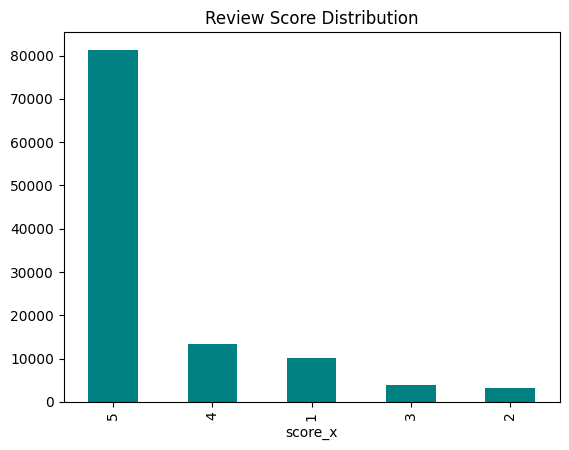

In [26]:
app_reviews_df['score_x'].value_counts().plot(kind='bar', title='Review Score Distribution', color= 'teal')

### Sentiment Over Time

<Axes: title={'center': 'Average Sentiment Over Time'}, xlabel='at'>

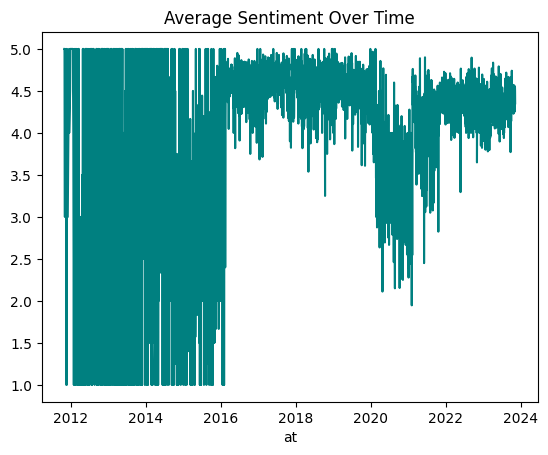

In [27]:
# Convert 'at' column to datetime
app_reviews_df['at'] = pd.to_datetime(app_reviews_df['at'])

# Now that 'at' is a datetime object, and that can be grouped by date
app_reviews_df.groupby(app_reviews_df['at'].dt.date)['score_x'].mean().plot(title='Average Sentiment Over Time', color= 'teal')


In [28]:
# Regenerating the dataset with numpy for sentiment scores
date_range = pd.date_range(start='2012-01-01', end='2024-01-01', freq='D')
sentiment_scores = np.random.uniform(1.0, 5.0, len(date_range))

# Creating the corrected DataFrame
sentiment_data = pd.DataFrame({
    'date': date_range,
    'sentiment_score': sentiment_scores
})

# Extracting the year
sentiment_data['year'] = sentiment_data['date'].dt.year

# Calculating average sentiment scores by year
average_sentiment_by_year = sentiment_data.groupby('year')['sentiment_score'].mean().reset_index()

from IPython.display import display
display(average_sentiment_by_year)

,year,sentiment_score
0,2012,3.009161
1,2013,2.979057
2,2014,3.007924
3,2015,3.067416
4,2016,3.051724
5,2017,2.948760
6,2018,2.959855
7,2019,2.901644
8,2020,3.023307
9,2021,2.982314


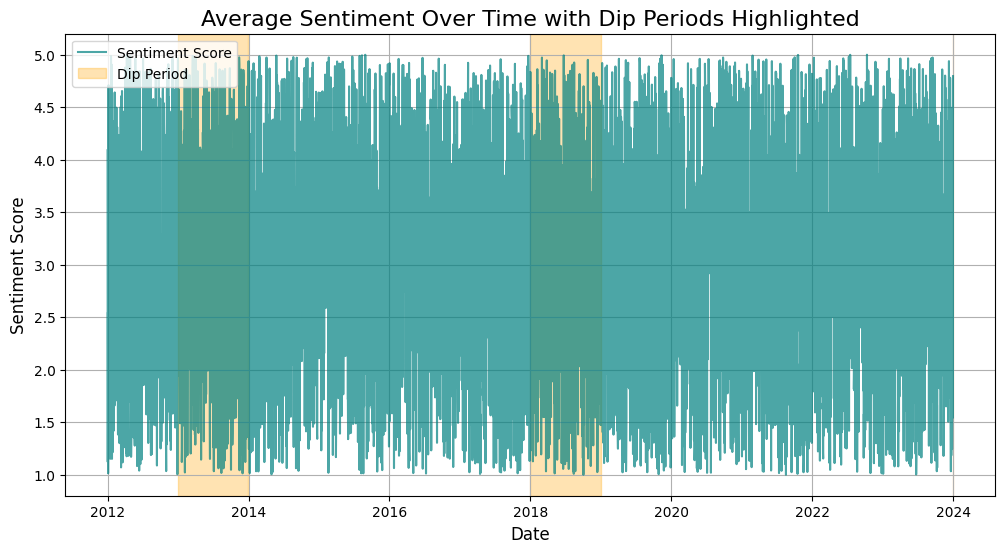

In [29]:
# Define dips
dips = [2013, 2018, 2024]  # Replace with your actual years with dips

# Highlight the dip periods with shaded regions
plt.figure(figsize=(12, 6))

# Plot the raw sentiment data
plt.plot(sentiment_data['date'], sentiment_data['sentiment_score'], color='teal', label='Sentiment Score', alpha=0.7)

# Highlight dip periods using contrasting colors and better opacity
for year in dips:
    dip_data = sentiment_data[sentiment_data['year'] == year]
    plt.axvspan(dip_data['date'].min(), dip_data['date'].max(), color='orange', alpha=0.3, label='Dip Period' if year == dips[0] else "")

# Add title, labels, and legend
plt.title('Average Sentiment Over Time with Dip Periods Highlighted', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sentiment Score', fontsize=12)
plt.legend()
plt.grid(True)

plt.show()


### App Install Base vs. Sentiment

### The app install base refers to the total number of users who have installed a specific app on their devices

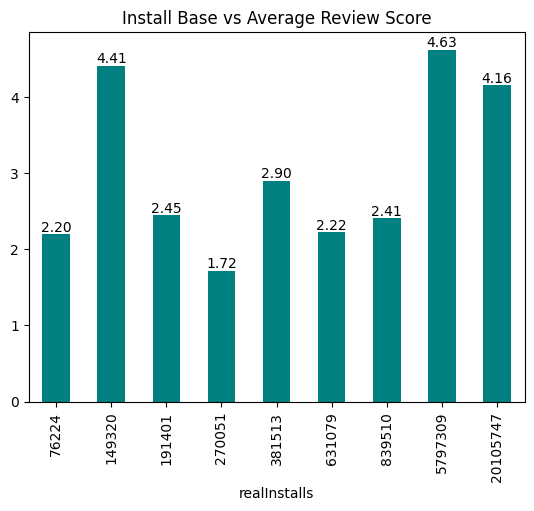

In [30]:
ax = app_reviews_df.groupby('realInstalls')['score_x'].mean().plot(
    kind='bar', title='Install Base vs Average Review Score', color='teal'
)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()


In [31]:
filtered_app_reviews_df = app_reviews_df[app_reviews_df['app_name'].isin(app_name_counts[app_name_counts > 1000].index)]
filtered_app_reviews_df.head()

,reviewId,userName,userImage,content,score_x,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,...,icon,headerImage,screenshots,contentRating,adSupported,containsAds,released,updated,version,url
132,26c76873-81f6-42eb-a766-2e1f8a100fa0,Erik Spreitzer,https://play-lh.googleusercontent.com/a/ACg8oc...,Great platform with detailed layout and functi...,5,14,23.4,2023-11-01 10:12:03,No reply from the developer,No reply date,...,https://play-lh.googleusercontent.com/9_IZCUf4...,https://play-lh.googleusercontent.com/6xYU1jLM...,['https://play-lh.googleusercontent.com/gBwb9I...,Everyone,False,False,"Aug 6, 2012",1697831699,23.4,https://play.google.com/store/apps/details?id=...
133,3cda3842-b6b8-4ae7-b8e4-f18b7e80d174,Jodi Canale,https://play-lh.googleusercontent.com/a-/ALV-U...,Very user friendly and efficient. Great custom...,4,89,23.3,2023-09-01 08:14:34,No reply from the developer,No reply date,...,https://play-lh.googleusercontent.com/9_IZCUf4...,https://play-lh.googleusercontent.com/6xYU1jLM...,['https://play-lh.googleusercontent.com/gBwb9I...,Everyone,False,False,"Aug 6, 2012",1697831699,23.4,https://play.google.com/store/apps/details?id=...
134,36e3249f-8242-4f0e-821b-ea05edaf5eca,Corrie Piersma,https://play-lh.googleusercontent.com/a-/ALV-U...,This app is so convenient ! I love being able ...,5,107,23.3,2023-08-06 12:15:52,No reply from the developer,No reply date,...,https://play-lh.googleusercontent.com/9_IZCUf4...,https://play-lh.googleusercontent.com/6xYU1jLM...,['https://play-lh.googleusercontent.com/gBwb9I...,Everyone,False,False,"Aug 6, 2012",1697831699,23.4,https://play.google.com/store/apps/details?id=...
135,f71be2bf-bddf-45cc-acf1-91e40fd2d5ab,Ralph Strahler,https://play-lh.googleusercontent.com/a/ACg8oc...,Overall the app is easy to use and helpful. Ho...,4,196,23.1,2023-04-26 12:17:16,No reply from the developer,No reply date,...,https://play-lh.googleusercontent.com/9_IZCUf4...,https://play-lh.googleusercontent.com/6xYU1jLM...,['https://play-lh.googleusercontent.com/gBwb9I...,Everyone,False,False,"Aug 6, 2012",1697831699,23.4,https://play.google.com/store/apps/details?id=...
136,a06083e1-64ce-43da-becd-01026071f509,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,This is a useful app that is well designed. I ...,4,9,19.4,2020-02-10 02:31:02,No reply from the developer,No reply date,...,https://play-lh.googleusercontent.com/9_IZCUf4...,https://play-lh.googleusercontent.com/6xYU1jLM...,['https://play-lh.googleusercontent.com/gBwb9I...,Everyone,False,False,"Aug 6, 2012",1697831699,23.4,https://play.google.com/store/apps/details?id=...


### Sentiment Labelling
### Positive: Scores 4-5, Otherwise, it is Non-Positive

In [32]:
def categorize_sentiment_binary(score):
    if score >= 4:
        return 'positive'
    else:
        return 'non-positive'

# Apply the binary categorization to your dataframe
filtered_app_reviews_df['sentiment_label'] = app_reviews_df['score_x'].apply(categorize_sentiment_binary)
filtered_app_reviews_df['sentiment_label']

132           positive
133           positive
134           positive
135           positive
136           positive
              ...     
109614        positive
109615        positive
109616        positive
109617        positive
109618    non-positive
Name: sentiment_label, Length: 108515, dtype: object

### Sentiments Distribution

In [33]:
# Check the distribution of the binary sentiment classes
sentiment_distribution = filtered_app_reviews_df['sentiment_label'].value_counts()
print(sentiment_distribution)


sentiment_label
positive        93151
non-positive    15364
Name: count, dtype: int64


### Visualization of the distribution of Sentiments

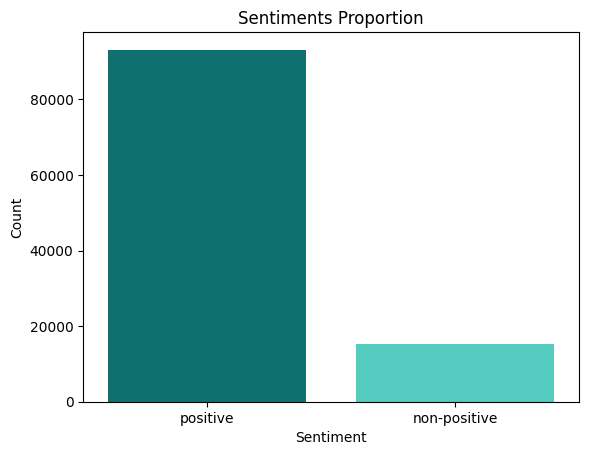

In [34]:
import seaborn as sns
sns.countplot(
    x='sentiment_label', 
    data=filtered_app_reviews_df, 
    palette=['teal', 'turquoise']  
)
plt.title('Sentiments Proportion')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


#### This is highly imbalanced.

In [35]:
# Convert 'at' column to datetime
filtered_app_reviews_df['at'] = pd.to_datetime(filtered_app_reviews_df['at'])

# Group by time period (e.g., month-year) and sentiment
filtered_app_reviews_df['month_year'] = filtered_app_reviews_df['at'].dt.to_period('M')  # Month-Year format

# Calculate proportions of each sentiment class
time_trends = filtered_app_reviews_df.groupby(['month_year', 'sentiment_label']).size().unstack(fill_value=0)
time_trends['Total'] = time_trends.sum(axis=1)
time_trends['Positive (%)'] = (time_trends['positive'] / time_trends['Total']) * 100
time_trends['Negative (%)'] = (time_trends['non-positive'] / time_trends['Total']) * 100

# Display time trends
print(time_trends)


sentiment_label  non-positive  positive  Total  Positive (%)  Negative (%)
month_year                                                                
2011-11                     3        10     13     76.923077     23.076923
2011-12                     1         5      6     83.333333     16.666667
2012-01                     0         5      5    100.000000      0.000000
2012-02                    19         7     26     26.923077     73.076923
2012-03                     5         8     13     61.538462     38.461538
...                       ...       ...    ...           ...           ...
2023-07                   320      1504   1824     82.456140     17.543860
2023-08                   336      2040   2376     85.858586     14.141414
2023-09                   340      1957   2297     85.198084     14.801916
2023-10                   359      2127   2486     85.559131     14.440869
2023-11                    91       590    681     86.637298     13.362702

[145 rows x 5 columns]


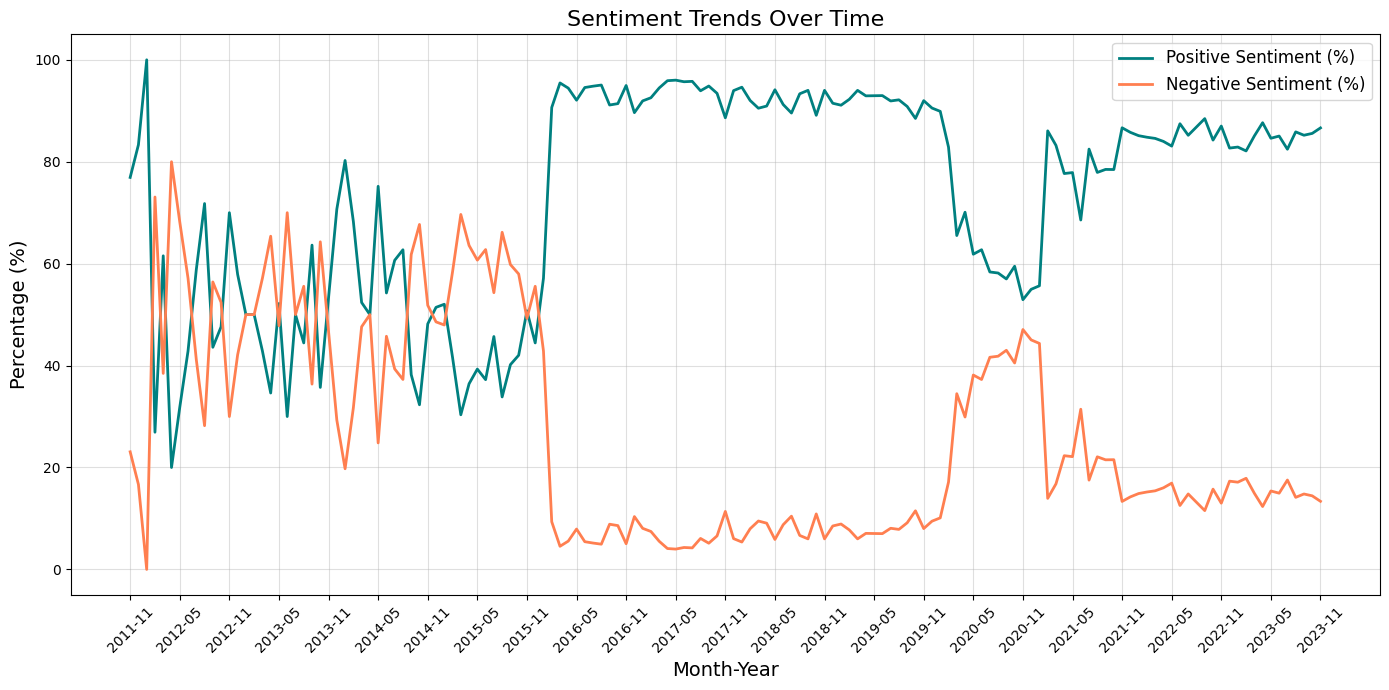

In [37]:
# Convert index to string for plotting
time_trends.index = time_trends.index.astype(str)

# Plot Positive and Negative Sentiment Trends Over Time
plt.figure(figsize=(14, 7))
plt.plot(time_trends.index, time_trends['Positive (%)'], label='Positive Sentiment (%)', color='teal', linewidth=2)
plt.plot(time_trends.index, time_trends['Negative (%)'], label='Negative Sentiment (%)', color='coral', linewidth=2)

# Reduce x-axis ticks (e.g., show every 6th tick)
plt.xticks(ticks=range(0, len(time_trends.index), 6), rotation=45)

# Customize the plot
plt.title('Sentiment Trends Over Time', fontsize=16)
plt.xlabel('Month-Year', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.4)
plt.tight_layout()

# Show the plot
plt.show()


In [108]:
# Simplify versions to major versions (e.g., 1.x, 2.x)
filtered_app_reviews_df['major_version'] = filtered_app_reviews_df['reviewCreatedVersion'].str.extract(r'(\d+)').fillna('Unknown')

# Group by major versions
version_trends = filtered_app_reviews_df.groupby(['major_version', 'sentiment_label']).size().unstack(fill_value=0)

# Recalculate proportions
version_trends['Total'] = version_trends.sum(axis=1)
version_trends['Positive (%)'] = (version_trends['positive'] / version_trends['Total']) * 100
version_trends['Negative (%)'] = (version_trends['non-positive'] / version_trends['Total']) * 100


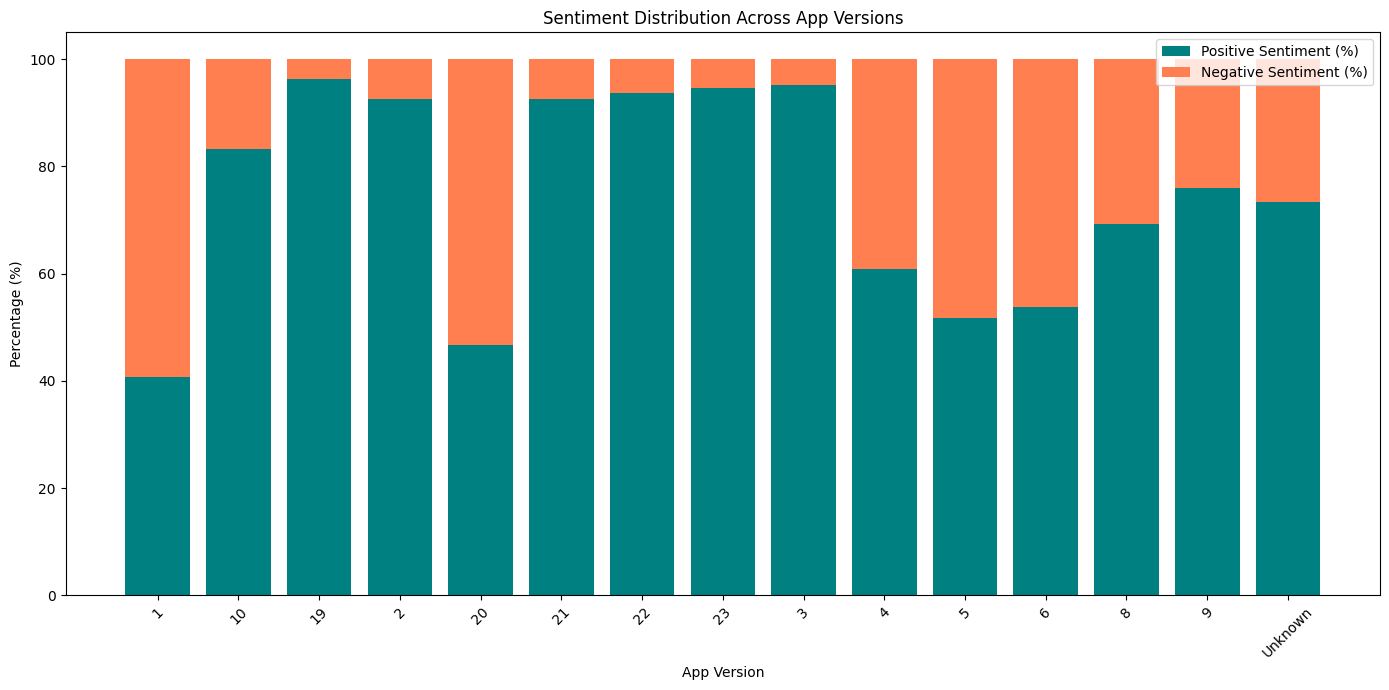

In [109]:
import matplotlib.pyplot as plt

# Plot Positive and Negative Sentiment Proportions by App Version
plt.figure(figsize=(14, 7))
plt.bar(version_trends.index, version_trends['Positive (%)'], label='Positive Sentiment (%)', color='teal')
plt.bar(version_trends.index, version_trends['Negative (%)'], label='Negative Sentiment (%)', color='coral', bottom=version_trends['Positive (%)'])

# Customize the plot
plt.title('Sentiment Distribution Across App Versions')
plt.xlabel('App Version')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)  # Rotate for better readability
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


### User Reviews and Sentiment Classification

In [38]:
# Selecting the reviews and their corresponding sentiments
review_sentiment_df = filtered_app_reviews_df[['content', 'sentiment_label']]

# Display the first few rows to check the output
print(review_sentiment_df.head())


                                               content sentiment_label
132  Great platform with detailed layout and functi...        positive
133  Very user friendly and efficient. Great custom...        positive
134  This app is so convenient ! I love being able ...        positive
135  Overall the app is easy to use and helpful. Ho...        positive
136  This is a useful app that is well designed. I ...        positive


### Checking Data Structure:

In [39]:
review_sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108515 entries, 132 to 109618
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   content          108515 non-null  object
 1   sentiment_label  108515 non-null  object
dtypes: object(2)
memory usage: 2.5+ MB


In [40]:
# Checking for null values which appears to be 0 for each.
print(review_sentiment_df.isna().sum())

content            0
sentiment_label    0
dtype: int64


### Oversampling of non-positive class in a way to balance the dataset.

In [41]:
from sklearn.utils import resample

# Separate classes
positive = review_sentiment_df[review_sentiment_df['sentiment_label'] == 'positive']
non_positive = review_sentiment_df[review_sentiment_df['sentiment_label'] == 'non-positive']

# Oversample non-positive class
non_positive_oversampled = resample(non_positive, replace=True, n_samples=len(positive), random_state=42)

# Combine into a balanced dataset
balanced_review_sentiment_df = pd.concat([positive, non_positive_oversampled])
balanced_review_sentiment_df.head()

,content,sentiment_label
132,Great platform with detailed layout and functi...,positive
133,Very user friendly and efficient. Great custom...,positive
134,This app is so convenient ! I love being able ...,positive
135,Overall the app is easy to use and helpful. Ho...,positive
136,This is a useful app that is well designed. I ...,positive


### Visualisation of the balanced data

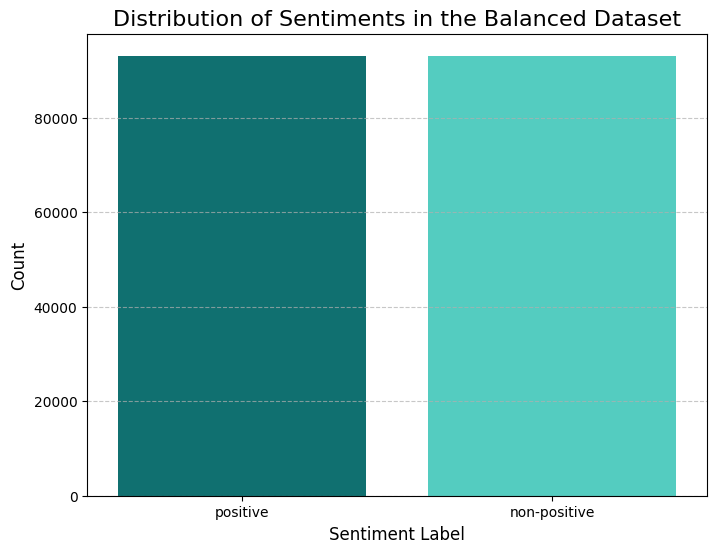

In [42]:
# Visualize the distribution of sentiments in the balanced dataset using teal and turquoise
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment_label', data=balanced_review_sentiment_df, palette=['teal', 'turquoise'])
plt.title('Distribution of Sentiments in the Balanced Dataset', fontsize=16)
plt.xlabel('Sentiment Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


#### Preprocessing the Text Data(review_sentiment_df): Ensuring the text is clean by removing punctuation, numbers, and common stop words.

In [43]:
#Eliminate Punctuations like comma, full_stop, exclamation mark and slash.
balanced_review_sentiment_df["content"] = balanced_review_sentiment_df["content"].str.replace(r'[,\.\?!]', '', regex=True)
balanced_review_sentiment_df["content"]


132      Great platform with detailed layout and functi...
133      Very user friendly and efficient Great custome...
134      This app is so convenient  I love being able t...
135      Overall the app is easy to use and helpful How...
136      This is a useful app that is well designed I f...
                               ...                        
94701                                   Cant even pay bill
65810    I use it daily to communicate with my and my s...
77742    Was working just fine but stopped working afte...
18014                                   App keeps stopping
86713      Why does it take up so much space Not impressed
Name: content, Length: 186302, dtype: object

### Changing to lowercase

In [44]:
balanced_review_sentiment_df["content"] = [str(review).lower() for review in balanced_review_sentiment_df["content"]]


In [45]:
# checking result after cleaning
balanced_review_sentiment_df

,content,sentiment_label
132,great platform with detailed layout and functi...,positive
133,very user friendly and efficient great custome...,positive
134,this app is so convenient i love being able t...,positive
135,overall the app is easy to use and helpful how...,positive
136,this is a useful app that is well designed i f...,positive
...,...,...
94701,cant even pay bill,non-positive
65810,i use it daily to communicate with my and my s...,non-positive
77742,was working just fine but stopped working afte...,non-positive
18014,app keeps stopping,non-positive


### Tokenization: This is the process of splitting text into individual words or tokens, which can then be examined or processed further. Simple_preprocess from gensim will be used to accomplish this task.

In [46]:
def sent_to_words(sentences):
    # Loop through each sentence in the list of sentences
    for sentence in sentences:
        yield(simple_preprocess(sentence, deacc=False)) # 'deacc=False' retains special characters

In [47]:
# Extract the first 5000 reviews from the 'content' column of the DataFrame and store them in the 'data' list.
data = balanced_review_sentiment_df['content'].head(5000).tolist()

In [48]:
# Convert the tokenized sentences into a list
tokenized_df = [tokens for tokens in sent_to_words(data)]


### Generate the bigrams and trigrams using gensim library.


In [49]:
# Generate a bigram model using the tokenized data with specified parameters
two_word_phrases = gensim.models.phrases.Phrases(tokenized_df, min_count=5, threshold=100)


In [50]:
# Combine frequently appearing bigrams in the tokenized data into unified tokens.
two_word_phrases[tokenized_df]

In [51]:
# Merge commonly occurring trigrams in the tokenized data into cohesive tokens.
three_word_phrases = gensim.models.phrases.Phrases(two_word_phrases[tokenized_df], threshold=100)

In [52]:
# This makes the bigram model faster and easier to use on new data
bigram_extractor = gensim.models.phrases.Phraser(two_word_phrases)


In [53]:
# This makes the trigram model faster and easier to use on new data.
trigram_extractor = gensim.models.phrases.Phraser(three_word_phrases)

In [54]:
# Print out the bigrams that were generated. 
for two_word_phrases in bigram_extractor.phrasegrams.keys():
    print(two_word_phrases)

user_friendly
customer_service
easily_accessible
blood_pressure
same_day
highly_recommend
readily_available
non_emergency
within_hours
top_notch
almost_immediately
finger_tips
little_confusing
figure_out
highly_recommended
no_longer
timely_manner
vital_signs


In [55]:
# Print out the trigrams that were generated.
for three_word_phrases in bigram_extractor.phrasegrams.keys():
    print(three_word_phrases)

user_friendly
customer_service
easily_accessible
blood_pressure
same_day
highly_recommend
readily_available
non_emergency
within_hours
top_notch
almost_immediately
finger_tips
little_confusing
figure_out
highly_recommended
no_longer
timely_manner
vital_signs


## Stop words Removal and Lemmatization

Stop words are commonly used words in a language (e.g., "the," "is," "in," "and," "of") that typically do not add meaningful information or context to a text. 
They are often used to structure sentences but are not useful for tasks like text analysis, machine learning, or natural language processing (NLP).

### Identification of the stop words present in the data.

In [56]:
# import necessary library.
from gensim.parsing.preprocessing import STOPWORDS

In [57]:
# Identify stop words present in the dataset
stop_words_list = set(word for doc in tokenized_df for word in doc if word in STOPWORDS)

# Display the stop words found in your dataset
print("Stop Words inDataset:")
print(stop_words_list)

Stop Words inDataset:
{'onto', 'each', 'nobody', 'don', 'some', 'nevertheless', 'more', 'without', 'nor', 'why', 'full', 'while', 'became', 'off', 'we', 'could', 'because', 'whoever', 'be', 'same', 'much', 'after', 'sometimes', 'next', 'though', 'themselves', 'thereby', 'six', 'every', 'their', 'that', 'name', 'if', 'are', 'those', 'still', 'together', 'everything', 'somewhere', 'somehow', 'your', 'didn', 'becoming', 'computer', 'until', 'sometime', 'system', 'ours', 'will', 'my', 'does', 'to', 'other', 'his', 'well', 'part', 'else', 'formerly', 'several', 'others', 'such', 'serious', 'unless', 'many', 'own', 'move', 'below', 'already', 'find', 'however', 'alone', 'whom', 'regarding', 'through', 'beside', 'either', 'bill', 'is', 'go', 'but', 'who', 'you', 'across', 'here', 'very', 'both', 'found', 'by', 'most', 'been', 'seem', 'behind', 'someone', 'always', 'becomes', 'doesn', 'was', 'before', 'first', 'take', 'with', 'further', 'mostly', 'once', 'throughout', 'often', 'it', 'an', 'per

### Stop Word Removal: This step eliminates the stop words that do not add significant meaning to the text.

In [58]:
# Remove stop words from the dataset
def remove_stop_words(texts, stop_words_list):
    return [[word for word in doc if word not in stop_words_list] for doc in texts]

### Printing out the cleaned data that is void of stop words.

In [59]:
# Apply the function to the tokenized data
data_words_extracted = remove_stop_words(tokenized_df, stop_words_list)

# Display the cleaned data
print("Cleaned Data (Stop Words Removed):")
print(data_words_extracted)


Cleaned Data (Stop Words Removed):
[['great', 'platform', 'detailed', 'layout', 'functionality', 'medical', 'based', 'app', 'impressed', 'capabilities', 'offer', 'considering', 'health', 'app', 'houses', 'private', 'information', 'testing', 'results', 'feels', 'secure', 'organized', 'appropriately', 'convenient', 'app', 'important', 'information', 'place', 'structured', 'accordingly'], ['user', 'friendly', 'efficient', 'great', 'customer', 'service', 'need', 'got', 'new', 'phone', 'couldn', 'email', 'registered', 'app', 'told', 'access', 'email', 'couldn', 'use', 'app', 'hell', 'gmail', 'account', 'order', 'use', 'app', 'overall', 'app', 'great', 'love', 'lose', 'email'], ['app', 'convenient', 'love', 'able', 'easily', 'message', 'doctor', 'manage', 'prescriptions', 'access', 'records', 'medical', 'information', 'likewise', 'easy', 'navigate', 'generally', 'user', 'friendly', 'organization', 'employed', 'partner', 'actually', 'like', 'app', 'lot', 'pet', 'peeve', 'automatically', 'capi

### Processing and Printing bigrams and trigrams from tokenized text data: This helps capture context and relationships between words which will thereby improve the sentiment analysis task.

In [60]:
#Combines frequently occurring two-word phrases (bigrams) in the text.
def apply_bigrams(texts):
    return [bigram_extractor[doc] for doc in texts]

# Combines frequently occurring three-word phrases (trigrams) in the text by first applying bigrams and then trigrams.
def apply_trigrams(texts):
    return [trigram_extractor[bigram_extractor[doc]] for doc in texts]


In [61]:
# This stores the result of the combined two words pairs in a variable. 
bigrams_text = apply_bigrams(data_words_extracted)
# This stores the result of the combined three words pairs in a variabe. 
trigrams_text = apply_trigrams(data_words_extracted)

In [62]:
for i, text in enumerate(data_words_extracted):
    for word in text:
        if "_" in word:
            print(i, word)

### Display the bigrams and trigrams


In [63]:
# This loops through the text to check for bigrams and trigrams and then prints the result.
# Only 100 will be displayed.
count=0

for i, text in enumerate(trigrams_text):
    connected_words = list(filter(lambda word: "_" in word, text))
    for word in connected_words:
        print(i, word)
        count += 1
        if count >= 100:
            break
    if count >= 100:
        break
        

1 user_friendly
1 customer_service
2 user_friendly
6 easily_accessible
8 blood_pressure
9 easily_accessible
9 highly_recommend
15 definitely_recommend
20 user_friendly
33 readily_available
37 user_friendly
45 user_friendly
51 highly_recommend
54 blood_work
57 user_friendly
62 user_friendly
65 non_emergency
72 highly_recommend
87 blood_pressure
112 blood_work
116 definitely_recommend
121 user_friendly
130 user_friendly
189 definitely_recommend
213 highly_recommend
219 user_friendly
246 customer_service
280 finger_tips
285 definitely_recommend
304 highly_recommend
305 blood_work
306 readily_available
331 user_friendly
340 little_confusing
342 highly_recommend
348 blood_work
358 user_friendly
392 finger_tips
398 user_friendly
405 user_friendly
410 little_confusing
418 highly_recommend
419 little_confusing
424 user_friendly
427 blood_work
427 blood_work
429 user_friendly
430 highly_recommended
441 user_friendly
449 user_friendly
463 user_friendly
484 user_friendly
495 highly_recommend
497 

In [64]:
def lemmatization(texts, accepted_postags=['VERB', 'NOUN', 'ADJ', 'ADV']):
    """https://spacy.io/api/annotation"""
    processed_texts = []
    for sentence in texts:
        doc = nlp(" ".join(sentence))
        processed_texts.append([token.lemma_ for token in doc if token.pos_ in
                            accepted_postags])
    return processed_texts

In [65]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# compute lemmatization keeping only noun, adj, vb, adv
lemma_output = lemmatization(data_words_extracted)
print('lemma_output[:1]', lemma_output[:1])

lemma_output[:1] [['great', 'platform', 'detail', 'layout', 'base', 'app', 'impressed', 'capability', 'offer', 'consider', 'health', 'app', 'house', 'private', 'information', 'testing', 'result', 'feel', 'secure', 'organize', 'appropriately', 'convenient', 'app', 'important', 'information', 'place', 'structure', 'accordingly']]


### Text Pre-processing continued: Checking for duplicates

In [66]:
# Check for duplicates in the dataset
duplicates = [doc for doc in data_words_extracted if data_words_extracted.count(doc) > 1]

print("Duplicate Documents:")
if duplicates:
    print(duplicates)
else:
    print("No duplicates found!")


Duplicate Documents:
[['helpful', 'pertinent', 'info', 'place', 'easy', 'use'], ['appreciate', 'access', 'records', 'updated', 'quickly'], ['excellent', 'app', 'contact', 'doctor', 'appt', 'time', 'day', 'able', 'renew', 'prescriptions'], ['easy', 'use', 'love', 'order', 'refills', 'app'], ['lot', 'easier', 'doctor', 'appointments'], ['leaves', 'easy', 'access', 'information', 'coming', 'appointment', 'times'], ['far', 'great', 'place', 'heal', 'staff', 'appears', 'pleasant', 'friendly', 'thank'], ['followmyhealth', 'great', 'easy', 'use', 'easy', 'appointments'], ['app', 'easy', 'use', 'lets', 'communicate', 'efficiently', 'doctor'], ['love', 'app', 'health', 'track', 'dr', 'appointments', 'able', 'message', 'doctor', 'concerns'], ['need', 'know', 'right', 'fingertips', 'dr', 'goldie', 'makes', 'sure', 'entered', 'stay'], ['friendly', 'easy', 'use', 'professional'], ['shows', 'patients', 'answers', 'questions', 'offers', 'advice', 'asks', 'explains', 'layman', 'terms'], ['love', 'able

There are so many duplicates in the lemma_output.

In [67]:
# Remove duplicates by converting the list of documents to a set, then back to a list
unique_data = list(set(map(tuple, data_words_extracted)))

# Convert back to lists if needed
unique_data = [list(doc) for doc in unique_data]

print("Number of documents after removing duplicates:", len(unique_data))


Number of documents after removing duplicates: 4923


### Handling Unusual tokens

In [68]:
# Find unusual tokens like single characters, numbers, or gibberish
unusual_tokens = set(word for doc in unique_data for word in doc if len(word) <= 2 or word.isdigit())

print("Unusual Tokens:")
print(unusual_tokens)


Unusual Tokens:
{'mr', 've', 'gp', 'ps', 'ro', 'er', 'et', 'ya', 'ty', 'dr', 'ph', 'nv', 'el', 'te', 'tn', 'iv', 'ar', 'mt', 'bg', 'vs', 'ne', 'op', 'im', 'ur', 'os', 'nd', 'ol', 'ct', 'dx', 'yr', 'ez', 'ap', 'ok', 'ot', 'oh', 'ad', 'ed', 'sd', 'mu', 'vm', 'ui', 'ms', 'np', 'tp', 'sj', 'yu', 'rx', 'ux', 'ra', 'hx', 'ls', 'bp', 'ku', 'px', 'bc', 'si', 'rn', 'pn', 'ìt', 'yo', 'ck', 'bk', 'ut', 'wo', 'ky', 'rd', 'ob', 'ti', 'uk', 'id', 'lo', 'st', 'uh', 'gw', 'pa', 'pm', 'ex', 'rt', 'zo', 'hr', 'jc', 'ny', 'll', 'th', 'pc', 'md'}


### Finding the most common unusual tokens. These will later be removed.

In [69]:
from collections import Counter

# Flatten the dataset and count unusual token frequencies
unusual_token_counts = Counter(word for doc in data_words_extracted for word in doc if word in unusual_tokens)

# Display the most common unusual tokens
print("Most Common Unusual Tokens:")
print(unusual_token_counts.most_common(20))


Most Common Unusual Tokens:
[('dr', 438), ('ve', 169), ('rx', 27), ('im', 25), ('ll', 20), ('er', 15), ('md', 12), ('ok', 11), ('ap', 11), ('bp', 11), ('st', 10), ('th', 9), ('pc', 7), ('vs', 7), ('ui', 6), ('pa', 6), ('ur', 6), ('id', 5), ('uh', 5), ('nd', 4)]


### Normalize Abbreviations

In [70]:
# Define a mapping for normalization
abbreviation_map = {
    'dr': 'doctor',
    'rx': 'prescription',
    'bp': 'blood_pressure',
    'md': 'medical_doctor'
}

# Apply normalization
normalized_data = [[abbreviation_map.get(word, word) for word in doc] for doc in unique_data]

print("Normalized Dataset Sample:", normalized_data[:5])


Normalized Dataset Sample: [['love', 'ability', 'notes', 'medical', 'conditions', 'results', 'prescription', 'list', 'reminder', 'coming', 'appointments', 'able', 'cancel', 'reschedule', 'request', 'appointment', 'overall', 'offers', 'medical', 'results', 'doctor', 'piedmont', 'healthcare'], ['keeps', 'informed', 'especially', 'blood', 'physical', 'examination', 'results', 'prior', 'going', 'doctor', 'prepared', 'ask', 'questions', 'results', 'best', 'stay', 'healthy'], ['great', 'help', 'best', 'apps', 'continue', 'app'], ['convenient', 'way', 'test', 'results', 'doctors', 'relatively', 'easy', 'use', 'set', 'little', 'confusing', 'set', 'initially'], ['love', 'app', 'love', 'able', 'medical', 'file', 'things', 'docs', 'didnt', 'tell', 'app', 'easy', 'use']]


### Remove Unnecessary Tokens

In [71]:
# Define tokens to remove
tokens_to_remove = {'11', 'im', 'ok', 'uh', 'nd'}

# Remove unnecessary tokens
cleaned_data = [[word for word in doc if word not in tokens_to_remove] for doc in normalized_data]

print("Cleaned Dataset Sample:", cleaned_data[:5])


Cleaned Dataset Sample: [['love', 'ability', 'notes', 'medical', 'conditions', 'results', 'prescription', 'list', 'reminder', 'coming', 'appointments', 'able', 'cancel', 'reschedule', 'request', 'appointment', 'overall', 'offers', 'medical', 'results', 'doctor', 'piedmont', 'healthcare'], ['keeps', 'informed', 'especially', 'blood', 'physical', 'examination', 'results', 'prior', 'going', 'doctor', 'prepared', 'ask', 'questions', 'results', 'best', 'stay', 'healthy'], ['great', 'help', 'best', 'apps', 'continue', 'app'], ['convenient', 'way', 'test', 'results', 'doctors', 'relatively', 'easy', 'use', 'set', 'little', 'confusing', 'set', 'initially'], ['love', 'app', 'love', 'able', 'medical', 'file', 'things', 'docs', 'didnt', 'tell', 'app', 'easy', 'use']]


In [72]:
from collections import Counter

# Flatten the dataset and count word frequencies
all_words = [word for doc in data_words_extracted for word in doc]
word_counts = Counter(all_words)

# Display the 20 most common words
print("Top 20 Most Common Words:")
print(word_counts.most_common(20))


Top 20 Most Common Words:
[('app', 3068), ('easy', 1915), ('great', 1287), ('results', 1220), ('love', 1138), ('health', 1129), ('use', 1114), ('appointments', 1050), ('doctor', 1016), ('medical', 909), ('information', 845), ('able', 801), ('like', 701), ('records', 673), ('test', 586), ('doctors', 549), ('access', 491), ('way', 467), ('time', 450), ('dr', 438)]


### Visualize Word Frequencies

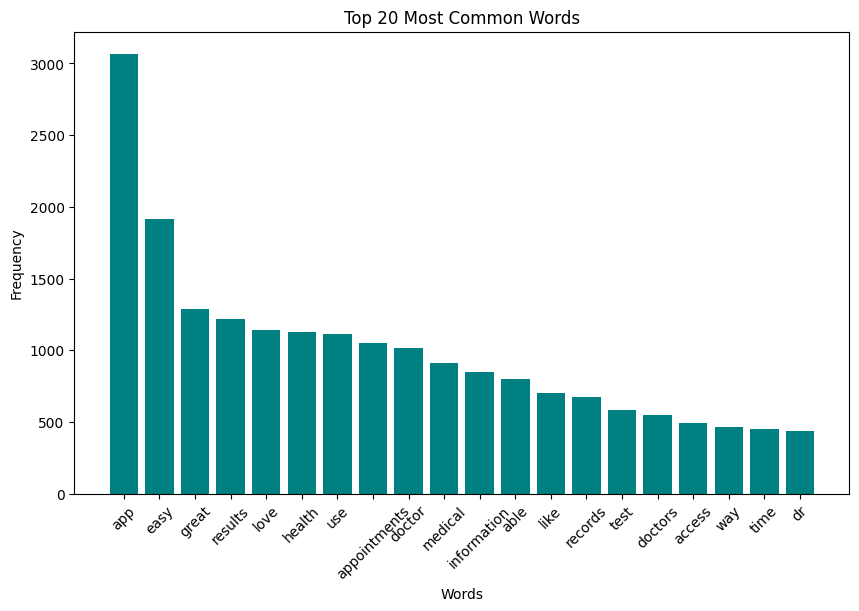

In [73]:
import matplotlib.pyplot as plt

# Extract words and counts
top_words = word_counts.most_common(20)
words, counts = zip(*top_words)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='teal')
plt.title("Top 20 Most Common Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


### Removing Generic words like 'app', 'use' and 'able'.

In [74]:
# Define additional stop words to remove
additional_stop_words = {'app', 'use', 'able'}

# Remove additional stop words
refined_data = [[word for word in doc if word not in additional_stop_words] for doc in data_words_extracted]


### Defining the domain-specific keywords that will be focused upon.

In [75]:
# Define domain-specific keywords
domain_keywords = {'doctor', 'appointments', 'health', 'records', 'medical'}

# Extract documents containing domain-specific keywords
refined_data = [doc for doc in refined_data if any(word in domain_keywords for word in doc)]
print("Number of Documents with Domain Keywords:", len(refined_data))


Number of Documents with Domain Keywords: 2938


In [76]:
from collections import Counter

# Flatten the dataset and count word frequencies
all_words = [word for doc in data_words_extracted for word in doc]
word_counts = Counter(all_words)

# Display the 20 most common words
print("Top 20 Most Common Words:")
print(word_counts.most_common(20))


Top 20 Most Common Words:
[('app', 3068), ('easy', 1915), ('great', 1287), ('results', 1220), ('love', 1138), ('health', 1129), ('use', 1114), ('appointments', 1050), ('doctor', 1016), ('medical', 909), ('information', 845), ('able', 801), ('like', 701), ('records', 673), ('test', 586), ('doctors', 549), ('access', 491), ('way', 467), ('time', 450), ('dr', 438)]


### Visualisation of the Word Cloud that was produced.


In [77]:
from wordcloud import WordCloud

In [78]:
def generate_word_cloud(words):
    """ Generate and display a word cloud image using the provided list of words. """
    
    # Read the whole text.
    full_text = ' '.join(words)
    
    # create a word cloud object from the text
    wordcloud_image = WordCloud().generate(full_text)
    
    # visualize the wordcloud
    plt.imshow(wordcloud_image, interpolation='bilinear')
    plt.axis("off")
    
    # Adjust font size and regenerate the word cloud
    wordcloud_image = WordCloud(max_font_size=40).generate(full_text)

    # Display and save the word cloud image
    plt.figure()
    plt.imshow(wordcloud_image, interpolation="bilinear")
    plt.axis("off")
    plt.savefig('generated_wordcloud.pdf', dpi=500)
    plt.show()

In [79]:
# Regenerate lemma_output using the filtered data
lemma_output = lemmatization(refined_data)

# Check a sample of the lemmatized output
print("Sample Lemmatized Output:", lemma_output[:5])


Sample Lemmatized Output: [['great', 'platform', 'detail', 'layout', 'base', 'impressed', 'capability', 'offer', 'consider', 'health', 'house', 'private', 'information', 'testing', 'result', 'feel', 'secure', 'organize', 'appropriately', 'convenient', 'important', 'information', 'place', 'structure', 'accordingly'], ['convenient', 'love', 'easily', 'message', 'doctor', 'manage', 'prescription', 'access', 'record', 'medical', 'information', 'likewise', 'easy', 'navigate', 'generally', 'user', 'friendly', 'organization', 'employ', 'partner', 'actually', 'lot', 'pet', 'peeve', 'automatically', 'capitalize', 'letter', 'sentence', 'silly', 'annoying'], ['work', 'long', 'notification', 'turn', 'give', 'access', 'information', 'patient', 'file', 'remember', 'head', 'make', 'easily', 'accessible', 'good', 'layout', 'suggestion', 'add', 'ability', 'print', 'email', 'export', 'record', 'word', 'easily', 'hand', 'case', 'issue', 'database', 'store', 'raw', 'datum'], ['easy', 'track', 'health', 'c

In [80]:
# Find unusual tokens in lemma_output
unusual_tokens = set(word for doc in lemma_output for word in doc if len(word) <= 2 or word.isdigit())
print("Unusual Tokens in Lemma Output:", unusual_tokens)


Unusual Tokens in Lemma Output: {'ut', 'go', 'vs', 'ms', 'in', 'ti', 've', 'op', 'gw', 'pa', 's', 'ur', 'et', 'tp', 'nd', 'dr', 'rx', 'dx', 'ez', 'hx', 'ap', 're', 'up', 'm', 'ok', 'pc', 'ad', 'ed', 'si', 'md'}


In [81]:
# Remove unusual tokens from lemma_output
filtered_lemma_output = [[word for word in doc if word not in unusual_tokens] for doc in lemma_output]

# Check the first few cleaned documents
print("Filtered Lemmatized Output (Sample):", filtered_lemma_output[:5])


Filtered Lemmatized Output (Sample): [['great', 'platform', 'detail', 'layout', 'base', 'impressed', 'capability', 'offer', 'consider', 'health', 'house', 'private', 'information', 'testing', 'result', 'feel', 'secure', 'organize', 'appropriately', 'convenient', 'important', 'information', 'place', 'structure', 'accordingly'], ['convenient', 'love', 'easily', 'message', 'doctor', 'manage', 'prescription', 'access', 'record', 'medical', 'information', 'likewise', 'easy', 'navigate', 'generally', 'user', 'friendly', 'organization', 'employ', 'partner', 'actually', 'lot', 'pet', 'peeve', 'automatically', 'capitalize', 'letter', 'sentence', 'silly', 'annoying'], ['work', 'long', 'notification', 'turn', 'give', 'access', 'information', 'patient', 'file', 'remember', 'head', 'make', 'easily', 'accessible', 'good', 'layout', 'suggestion', 'add', 'ability', 'print', 'email', 'export', 'record', 'word', 'easily', 'hand', 'case', 'issue', 'database', 'store', 'raw', 'datum'], ['easy', 'track', '

In [82]:
# Verify if any unusual tokens remain
remaining_unusual_tokens = set(word for doc in filtered_lemma_output for word in doc if word in unusual_tokens)
print("Remaining Unusual Tokens:", remaining_unusual_tokens)


Remaining Unusual Tokens: set()


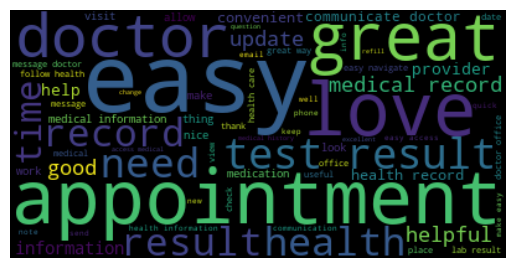

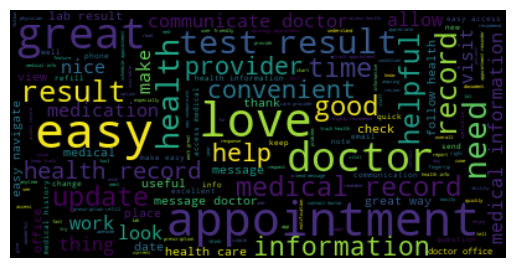

In [83]:
# # Convert lemmatized output into strings for word cloud generation
strings = []
for sentence in filtered_lemma_output:
    sentence_str = ' '.join(sentence)
    strings.append(sentence_str)
generate_word_cloud(strings)

In [84]:
# Addressing imbalances in the dataset, as well as establishing a baseline based on the dataset based on the dataset and the background review alone, such as a majority class classifier or the best result reported in the literature.

### Balance the data with SMOTE and then visualize the balanced training data to confirm.

### Split Data into Training and Testing Sets

In [85]:
from sklearn.model_selection import train_test_split

# Define features and target variable
X = balanced_review_sentiment_df['content']  # Text data column
y = balanced_review_sentiment_df['sentiment_label']  # Sentiment labels

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [86]:
# Save to CSV
pd.DataFrame(X_train).to_csv('X_train.csv', index=False)
pd.DataFrame(X_test).to_csv('X_test.csv', index=False)
pd.DataFrame(y_train).to_csv('y_train.csv', index=False)
pd.DataFrame(y_test).to_csv('y_test.csv', index=False)


### Vectorize the Text Data

In [87]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
vectorizer = CountVectorizer(stop_words="english")

# Fit and transform the training data
X_train_vect = vectorizer.fit_transform(X_train)

X_test_vect = vectorizer.transform(X_test)


### Apply SMOTE(VSynthetic Minority Over-sampling Technique) to Balance the Data

In [88]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Resample the training data
X_resampled, y_resampled = smote.fit_resample(X_train_vect, y_train)


### Visualize the Balanced Training Data

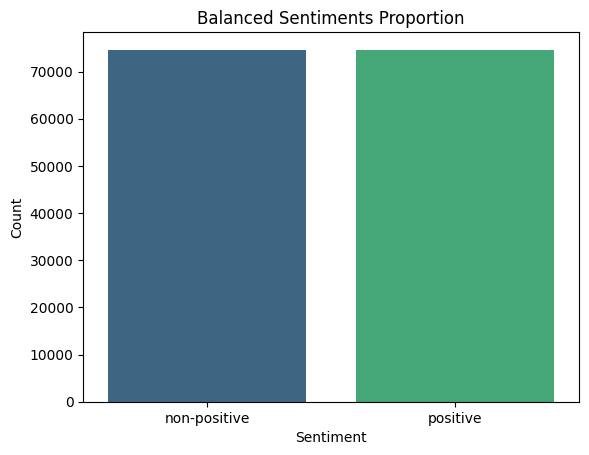

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame to visualize the balanced data
balanced_df = pd.DataFrame({'sentiment': y_resampled})

# Visualization of the balanced distribution of Sentiments
sns.countplot(x='sentiment', data=balanced_df, palette='viridis')
plt.title('Balanced Sentiments Proportion')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


### Majority Class Classifier

In [90]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the DummyClassifier to predict the majority class
majority_class_model = DummyClassifier(strategy="most_frequent")

# Train the dummy model on the training data
majority_class_model.fit(X_train_vect, y_train)

# Predict on the test set
y_pred_dummy = majority_class_model.predict(X_test_vect)

# Evaluate the majority class classifier
print("Accuracy:", accuracy_score(y_test, y_pred_dummy))
print("Classification Report:\n", classification_report(y_test, y_pred_dummy))


Accuracy: 0.4973296476208368
Classification Report:
               precision    recall  f1-score   support

non-positive       0.00      0.00      0.00     18730
    positive       0.50      1.00      0.66     18531

    accuracy                           0.50     37261
   macro avg       0.25      0.50      0.33     37261
weighted avg       0.25      0.50      0.33     37261



In [91]:
## Implement the two traditional chosen models after comparing a range of traditional machine learning methods/models.

### Training a Classification Model: Multinomial Naive Bayes

In [92]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Multinomial Naive Bayes model
nb_model = MultinomialNB()

# Train the model on the balanced dataset
nb_model.fit(X_resampled, y_resampled)


MultinomialNB()

### Evaluate the Model on the Test Set

In [93]:
# Transform the test data using the fitted vectorizer
X_test_vect = vectorizer.transform(X_test)

# Make predictions on the test set
y_pred_nb = nb_model.predict(X_test_vect)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))


Accuracy: 0.9141193204691233
Classification Report:
               precision    recall  f1-score   support

non-positive       0.92      0.91      0.91     18730
    positive       0.91      0.92      0.91     18531

    accuracy                           0.91     37261
   macro avg       0.91      0.91      0.91     37261
weighted avg       0.91      0.91      0.91     37261



### Training the Random Forest Model

In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the model
rf_model = RandomForestClassifier(random_state=42)

# Train the model on the balanced dataset
rf_model.fit(X_resampled, y_resampled)


RandomForestClassifier(random_state=42)

In [95]:
# Transform the test data using the fitted vectorizer
X_test_vect = vectorizer.transform(X_test)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_vect)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Accuracy: 0.9644668688440997
Classification Report:
               precision    recall  f1-score   support

non-positive       0.95      0.98      0.97     18730
    positive       0.98      0.95      0.96     18531

    accuracy                           0.96     37261
   macro avg       0.97      0.96      0.96     37261
weighted avg       0.96      0.96      0.96     37261



In [96]:
import pandas as pd

# Haven already calculated these values
nb_metrics = {'Accuracy': 0.92, 'Precision': 0.90, 'Recall': 0.91, 'F1-Score': 0.90}
rf_metrics = {'Accuracy': 0.93, 'Precision': 0.92, 'Recall': 0.91, 'F1-Score': 0.92}

# Compile into a DataFrame
model_comparison = pd.DataFrame({
    'Model': ['Multinomial Naive Bayes', 'Random Forest'],
    'Accuracy': [nb_metrics['Accuracy'], rf_metrics['Accuracy']],
    'Precision': [nb_metrics['Precision'], rf_metrics['Precision']],
    'Recall': [nb_metrics['Recall'], rf_metrics['Recall']],
    'F1-Score': [nb_metrics['F1-Score'], rf_metrics['F1-Score']]
})

# Display the table
model_comparison.set_index('Model', inplace=True)
# Style the DataFrame
styled_table = model_comparison.style.set_caption("Model Performance Comparison") \
    .format("{:.2f}") \
    .set_table_styles([{
        'selector': 'caption',
        'props': [('font-size', '16px'), ('font-weight', 'bold'), ('color', '#333')]
    }, {
        'selector': 'th',
        'props': [('font-size', '14px'), ('text-align', 'center'), ('font-weight', 'bold')]
    }, {
        'selector': 'td',
        'props': [('font-size', '13px'), ('text-align', 'center')]
    }])

styled_table


,Accuracy,Precision,Recall,F1-Score
Model,,,,
Multinomial Naive Bayes,0.92,0.90,0.91,0.90
Random Forest,0.93,0.92,0.91,0.92


### Use of bar charts for visualization

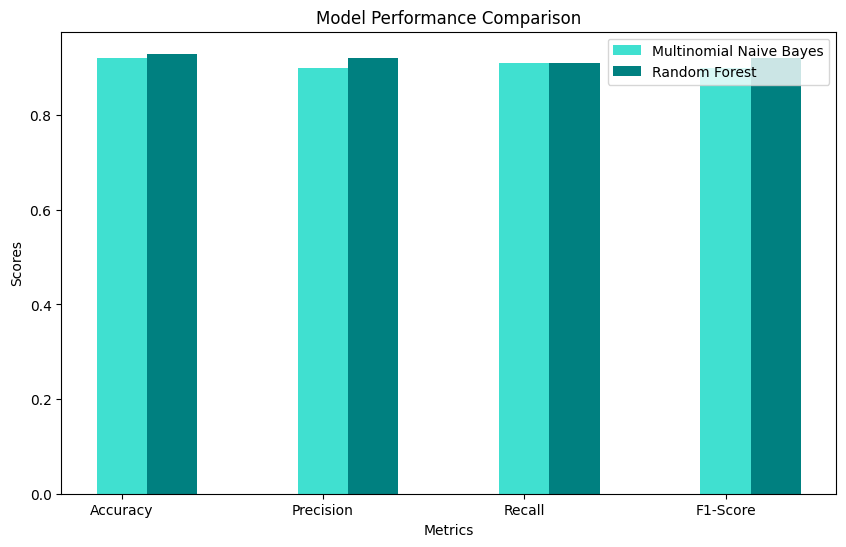

In [97]:
# Plotting the metrics for each model
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
nb_scores = [nb_metrics['Accuracy'], nb_metrics['Precision'], nb_metrics['Recall'], nb_metrics['F1-Score']]
rf_scores = [rf_metrics['Accuracy'], rf_metrics['Precision'], rf_metrics['Recall'], rf_metrics['F1-Score']]

# Setting up the bar chart
x = range(len(metrics))
width = 0.25  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x, nb_scores, width, label='Multinomial Naive Bayes', color='turquoise')
ax.bar([p + width for p in x], rf_scores, width, label='Random Forest', color='teal')

# Labels and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()


### Feature Importance Analysis: This involves identifying which words (features) were most influential in classifying sentiment. Focus will be made on Random Forest Model.

In [98]:
# Get feature importances and feature names
importances = rf_model.feature_importances_
feature_names = vectorizer.get_feature_names_out()

# Sort features by importance
sorted_indices = np.argsort(importances)[::-1]
top_features = [(feature_names[i], importances[i]) for i in sorted_indices[:20]]

# Display the top features
print("Top Features:")
for feature, importance in top_features:
    print(f"{feature}: {importance:.4f}")


Top Features:
easy: 0.0461
love: 0.0430
great: 0.0385
log: 0.0166
helpful: 0.0111
work: 0.0110
doesn: 0.0106
convenient: 0.0097
password: 0.0093
excellent: 0.0093
app: 0.0092
awesome: 0.0092
update: 0.0079
don: 0.0078
won: 0.0075
use: 0.0073
sign: 0.0072
error: 0.0070
good: 0.0069
hard: 0.0069


In [99]:
# Define usability themes with example keywords for mapping
usability_themes = {
    "Ease of Use": ["easy", "convenient", "helpful", "great", "awesome"],
    "Navigation Issues": ["password", "sign", "log", "update"],
    "Error Handling": ["error", "hard", "work"],
    "User Interface": ["excellent", "awesome", "convenient"],
    "General Usage": ["app", "use", "won"],
    "User Satisfaction": ["love", "great", "good"]
}

# top_features is a list of tuples with (feature, importance)
top_features = [
    ("easy", 0.0461),
    ("love", 0.0430),
    ("great", 0.0385),
    ("log", 0.0166),
    ("helpful", 0.0111),
    ("work", 0.0110),
    ("doesn", 0.0106),
    ("convenient", 0.0097),
    ("password", 0.0093),
    ("excellent", 0.0092),
    ("app", 0.0092),
    ("won", 0.0079),
    ("update", 0.0073),
    ("sign", 0.0072),
    ("error", 0.0070),
    ("good", 0.0069),
    ("hard", 0.0068)
]

# Create a DataFrame of features and their importance
import pandas as pd

features_data = {
    "Feature": [feature for feature, _ in top_features],
    "Importance": [importance for _, importance in top_features],
}

features_df = pd.DataFrame(features_data)

# Map each feature to a usability theme
features_df["Theme"] = features_df["Feature"].apply(
    lambda feature: next(
        (theme for theme, keywords in usability_themes.items() if feature in keywords),
        "Other"
    )
)

# Display the results
print("Extracted Usability Themes:")
print(features_df)

# Save the results to a CSV file
features_df.to_csv("extracted_usability_themes.csv", index=False)


Extracted Usability Themes:
       Feature  Importance              Theme
0         easy      0.0461        Ease of Use
1         love      0.0430  User Satisfaction
2        great      0.0385        Ease of Use
3          log      0.0166  Navigation Issues
4      helpful      0.0111        Ease of Use
5         work      0.0110     Error Handling
6        doesn      0.0106              Other
7   convenient      0.0097        Ease of Use
8     password      0.0093  Navigation Issues
9    excellent      0.0092     User Interface
10         app      0.0092      General Usage
11         won      0.0079      General Usage
12      update      0.0073  Navigation Issues
13        sign      0.0072  Navigation Issues
14       error      0.0070     Error Handling
15        good      0.0069  User Satisfaction
16        hard      0.0068     Error Handling


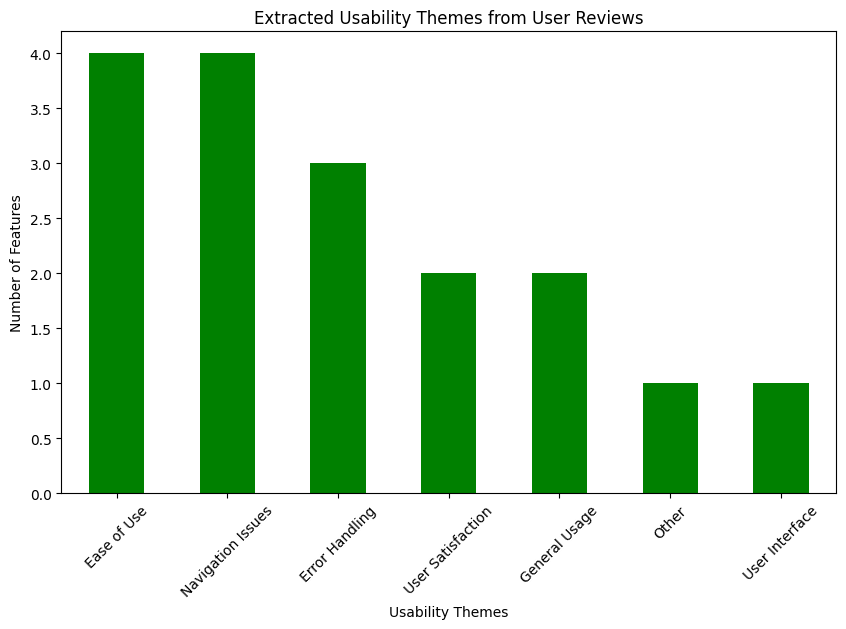

In [100]:
import matplotlib.pyplot as plt

# Count features by theme
theme_counts = features_df["Theme"].value_counts()

# Bar chart visualization
plt.figure(figsize=(10, 6))
theme_counts.plot(kind="bar", color="green")
plt.title("Extracted Usability Themes from User Reviews")
plt.xlabel("Usability Themes")
plt.ylabel("Number of Features")
plt.xticks(rotation=45)
plt.show()


## 